In [23]:
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np 
import seaborn as sns
import os, sys
from hsbmpy import get_file, define_labels, get_cluster_given_l, get_max_available_L
from geneontology import topic_analysis
import tensorflow as tf
from sklearn.metrics import homogeneity_completeness_v_measure
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from lda import lda
sys.path.append('/home/jovyan/phd/')
sys.path.append('/home/jovyan/phd/hsbm-occam/')

In [ ]:
import lda, importlib
importlib.reload(lda)
from lda import lda

In [35]:
level = 2
directory=r"/home/jovyan/work/phd/datasets/paper/gtex10seed"
#L=get_max_available_L(directory)
os.chdir(directory)
os.listdir()

['.DS_Store',
 'corpus.txt',
 'files.dat',
 'hierarchical-log',
 'hierarchical_dendogram.pdf',
 'lda',
 'mainTable.csv',
 'metric_scores_all.pdf',
 'p_t_s_lda.pdf',
 'p_t_s_topsbm.pdf',
 'p_w_lda.pdf',
 'p_w_topsbm.pdf',
 'p_w_tw_lda.pdf',
 'p_w_tw_topsbm.pdf',
 'tm',
 'topics_logp_topsbm_lda.pdf',
 'topsbm']

In [25]:
df = pd.read_csv("mainTable.csv", index_col=[0], header=[0]).dropna().astype(int)
totalobjcets = len(df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, ENSG00000268903 to ENSG00000008735
Columns: 17382 entries, GTEX-1117F-0226-SM-5GZZ7 to GTEX-ZZPU-2726-SM-5NQ8O
dtypes: int64(17382)
memory usage: 57.7+ MB


In [26]:
df_files = pd.read_csv("files.dat", index_col=[0])
df_files.head(3)

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
true_out = []
label = "SMTS"
if label not in df_files.columns:
    raise AttributeError(f"{label} not Avaliable")
for sample in df.columns.values:
    try:
        true_out.append(get_file(sample, df_files)[label])
    except:
        print(*sys.exc_info())
        true_out.append('unknown')

In [37]:
scores = {}

In [38]:
try:
    with open("clustersizes.txt",'r') as f:
        xl = np.sort(np.array(f.read().split(sep='\n'))[:-1].astype(int))
except:
        xl=np.linspace(2,50,5, dtype=int)
xl

array([ 2, 14, 26, 38, 50])

In [ ]:
xl = np.sort(np.concatenate([xl,np.arange(4,100,35)]))

In [30]:
xl=xl[:-1]
xl

array([11, 78])

## hierarchical

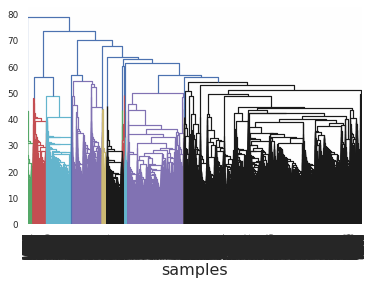

In [31]:
fig=plt.figure()
dend = shc.dendrogram(shc.linkage(np.log2(df.T.values+1), method='average'), leaf_rotation=90., leaf_font_size=8.,)
plt.xlabel("samples", fontsize=16)
plt.show()
fig.savefig("hierarchical_dendogram.pdf")

In [32]:
#hierarchical
scores['hierarchical']={
    'h':[],
    'c':[],
    'V':[]
}
def pearson_affinity(M, parallel=True):
    return 1 - np.array([[pearsonr(a,b)[0] for a in M] for b in M])

print("hierarchical-log")
os.system('mkdir -p hierarchical-log')
hierarchical_model = AgglomerativeClustering(n_clusters=1, affinity='euclidean', linkage='complete')  
for l,x in enumerate(xl):
    print("testing with %d clusters"%x)
    hierarchical_model.n_clusters=x
    #data = np.log2(1.+df.T.values)
    data = df.T.values
    out = hierarchical_model.fit_predict(data)
        
    #save clusters
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(len(df.columns)))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df.columns[np.argwhere(out==c)].T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(len(df.columns)-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierarchical-log/hierarchical-log_level_%d_clusters.csv"%(l), index=False, header=True)

hierarchical-log
testing with 11 clusters
saving clusters


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


testing with 78 clusters
saving clusters


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


## LDA

In [11]:
with open("topicsizes.txt",'r') as f:
    tl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

FileNotFoundError: [Errno 2] No such file or directory: 'topicsizes.txt'

In [39]:
xl = xl[:]
print(xl)

[ 2 14 26 38 50]


In [40]:
model=lda(n_jobs=4, verbose=2,  max_iter=5)
model.full_analysis(directory, xl, tl=None, logarithmise=True, label="SMTS")

model created
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, ENSG00000268903 to ENSG00000251322
Columns: 1000 entries, GTEX-1KWVE-2326-SM-D4P3N to GTEX-YB5K-0526-SM-5LUAS
dtypes: float64(1000)
memory usage: 22.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 22951 entries, GTEX-1117F-0003-SM-58Q7G to K-562-SM-E9EZZ
Data columns (total 62 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMATSSCR   15739 non-null  float64
 1   SMCENTER   22724 non-null  object 
 2   SMPTHNTS   15737 non-null  object 
 3   SMRIN      19998 non-null  float64
 4   SMTS       22951 non-null  object 
 5   SMTSD      22951 non-null  object 
 6   SMUBRID    22951 non-null  object 
 7   SMTSISCH   22650 non-null  float64
 8   SMTSPAX    15715 non-null  float64
 9   SMNABTCH   22575 non-null  object 
 10  SMNABTCHT  22575 non-null  object 
 11  SMNABTCHD  22575 non-null  object 
 12  SMGEBTCH   22228 non-null  object 
 13  SMGEBTCHD  22209 non-null 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


testing with 14 clusters and 14 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


testing with 26 clusters and 26 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished


testing with 38 clusters and 38 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.5s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished


testing with 50 clusters and 50 topics
lda(doc_topic_prior=1, learning_method='online', max_doc_update_iter=5,
    max_iter=5, random_state=42, topic_word_prior=1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.6s finished


In [ ]:
topic_analysis(directory,1, 'lda')

## LDA Mallet

In [ ]:
from gensim.models.wrappers import LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import get_tmpfile
from gensim.corpora import MmCorpus

In [ ]:
corpus=list(map(list,map(lambda x: list(zip(range(len(df.index)), df[x])),df.columns)))
corpus

In [ ]:
dictionary=Dictionary([df.index])
[a for a in dictionary.items()]

In [ ]:
out_file=get_tmpfile("/home/fvalle/phd/datasets/tcga/oversampling_10tissue/corpus.mm")
MmCorpus.serialize(out_file, corpus, dictionary)

In [ ]:
model = LdaMallet("/home/fvalle/phd/Mallet/bin/mallet", workers=5, corpus=corpus, num_topics=15, id2word=dictionary)

In [ ]:
df_topics=pd.DataFrame(data=model.get_topics().T, index=[a[1] for a in dictionary.items()], columns=["Topic %d"%(t+1) for t in range(5)])
df_topics

In [ ]:
df_topic_distr=pd.read_csv(model.fdoctopics(), sep='\t', header=None, index_col=0).drop(1,1)
df_topic_distr.columns=["Topic %d"%(t+1) for t in range(5)]
df_topic_distr.index=df.columns
df_topic_distr

In [ ]:
df_topic_distr.apply(lambda x: x.idxmax().split(" ")[1], axis=1)

## hierachical on Altmann's output

In [ ]:
hiermodel = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')

In [ ]:
with open('clustersizes.txt') as f:
    xl=np.array(f.read().split('\n')[:-1]).astype(int)

In [ ]:
os.system("mkdir -p hierhsbm")

In [ ]:
true_out = []
for sample in pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',0), index_col=1).drop('i_doc', axis=1).index.values:
    try:
        true_out.append(get_file(sample, df_files)['primary_site'])
    except:
        print(sys.exc_info()[0])
        true_out.append('')

In [ ]:
scores['hierhsbm']={
    'h':[],
    'c':[],
    'V':[]
}
for l,n_clusters in enumerate(xl):
    print("Fitting level %d with %d clusters"%(l, n_clusters))
    df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',l), index_col=1).drop('i_doc', axis=1)
    df_clusters = pd.DataFrame(columns=["Cluster %d"%c for c in np.arange(n_clusters)+1])
    hiermodel.n_clusters=n_clusters
    out = hiermodel.fit_predict(df_topics.values)  
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df_topics.index[np.argwhere(out==c)].values.T[0]
        df_clusters["Cluster %d"%(c+1)]=np.concatenate((c_objects,[np.nan for _ in np.arange(len(df_topics.index)-len(c_objects))]))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierhsbm/hierhsbm_level_%d_clusters.csv"%(l), index=False, header=True)
    #metrics
    print("saving metrics")
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['hierhsbm']['h'].append(score[0])
    scores['hierhsbm']['c'].append(score[1])
    scores['hierhsbm']['V'].append(score[2])
    
pd.DataFrame(data=scores['hierhsbm']).to_csv("%s/hierhsbm.scores"%directory, header=True, index=False)

## Topic mapping

In [ ]:
df_clusters = pd.read_csv("tm/tm_level_0_clusters.csv")

In [ ]:
out=[]
true_out=[]
for c in df_clusters.columns:
    for sample in df_clusters[c].dropna():
        out.append(c)
        true_out.append(get_file(sample, df_files)['primary_site'])

In [ ]:
score = (*homogeneity_completeness_v_measure(true_out, out), len(df_clusters.columns))
    
pd.DataFrame(data=score, index=['h','c','v', 'n']).transpose().to_csv("%s/tm.scores"%directory, header=True, index=False)

# t-SNE

## WGCNA

In [15]:
for l in range(5):
    df_wgcna = pd.read_csv("wgcna/wgcna_level_%d_labels.csv"%l, index_col=0)
    totalobjcets = len(df_wgcna.index)
    out = df_wgcna['x'].values
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(totalobjcets))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df_wgcna.index[np.argwhere(out==(c+1))].T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(totalobjcets-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("wgcna/wgcna_level_%d_clusters.csv"%l, index=False, header=True)
df_wgcna_td = pd.read_csv("wgcna/wgcna_level_0_topic-dist.csv")
df_wgcna_td.columns.values[0]='doc'
df_wgcna_td.index.name='i_doc'
df_wgcna_td.to_csv("wgcna/wgcna_level_0_topic-dist.csv", index=True)

saving clusters


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


saving clusters
saving clusters
saving clusters
saving clusters


In [16]:
df_wgcna_td = pd.read_csv("wgcna/wgcna_level_0_topic-dist.csv").drop(['doc'], axis=1)
df_wgcna_td.columns.values[1]='doc'
df_wgcna_td
df_wgcna_td.to_csv("wgcna/wgcna_level_0_topic-dist.csv", index=False)

## hSBM

In [ ]:
for l in range(3):
    pd.read_csv("topsbm/topsbm_level_%d_topics.csv"%l).applymap(lambda x: str(x)[:15]).to_csv("topsbm/topsbm_level_%d_topics.csv"%l, index=False)